In [105]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [106]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [107]:
NUM_CLASSES = 12
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 

# Dataset reading

In [108]:
def apply_rotation(label, points):
    num_points = 21
    point_0 = points[0]
    point_8 = points[8]

    if label == 'dislike' or label == 'like':
        return points  # No rotation
    elif label == 'call':
        # Rotate to be parallel with X-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[0])  # Consider the X-Z plane
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    else:
        # Rotate to be parallel with Y-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[1])  # Consider the Y-Z plane
        rotation_matrix = np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    
    # Apply rotation
    for i in range(num_points):
        points[i] = np.dot(rotation_matrix, points[i])

    return points


In [109]:
def pre_process_dataset(X_dataset, y_dataset):
    # Reshape to 3D
    num_points = 21
    reshaped_dataset = X_dataset.reshape(-1, num_points, 3)

    # Shift coordinates
    for i in range(len(reshaped_dataset)):
        base_point = reshaped_dataset[i, 0]  # ID:0
        for j in range(num_points):
            reshaped_dataset[i, j] -= base_point

    # Rotation
    for i in range(len(reshaped_dataset)):
        label = LABELS[y_dataset[i]]
        reshaped_dataset[i] = apply_rotation(label, reshaped_dataset[i])

    # Flatten
    flattened_dataset = reshaped_dataset.reshape(-1, num_points * 3)

    # Normalization
    max_abs_value = np.max(np.abs(flattened_dataset))
    normalized_dataset = flattened_dataset / max_abs_value

    return normalized_dataset

In [110]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [111]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [112]:
X_dataset_preprocessed = pre_process_dataset(X_dataset, y_dataset)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_preprocessed, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [114]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(32, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [115]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 63)                0         
                                                                 
 dense_15 (Dense)            (None, 128)               8192      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                      

In [116]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [117]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [118]:
es_callback

In [119]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


56/71 [======================>.......] - ETA: 0s - loss: 2.4559 - accuracy: 0.1682
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 1s 6ms/step - loss: 2.3896 - accuracy: 0.1894 - val_loss: 2.4031 - val_accuracy: 0.1697
Epoch 2/1000
67/71 [===========================>..] - ETA: 0s - loss: 1.9376 - accuracy: 0.3317
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.9298 - accuracy: 0.3348 - val_loss: 2.1589 - val_accuracy: 0.2673
Epoch 3/1000
65/71 [==========================>...] - ETA: 0s - loss: 1.7295 - accuracy: 0.3906
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 3ms/step - loss: 1.7248 - accuracy: 0.3931 - val_loss: 1.8168 - val_accuracy: 0.3713
Epoch 4/1000
56/71 [======================>.......] - ETA: 0s - loss: 1.6119 - accuracy: 0.4325
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [120]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/24 [>.............................] - ETA: 0s - loss: 0.2171 - accuracy: 0.9141

24/24 [==============================] - 0s 2ms/step - loss: 0.2671 - accuracy: 0.9010


In [121]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [122]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 80ms/step
[2.2248141e-10 9.9999774e-01 2.6963404e-11 4.2042059e-13 7.0515653e-13
 1.7591608e-06 3.0899474e-12 2.8840304e-07 4.1970494e-10 3.4260172e-09
 9.5407010e-08 2.0024961e-08]
1


# Confusion matrix

94/94 [==============================] - 0s 827us/step


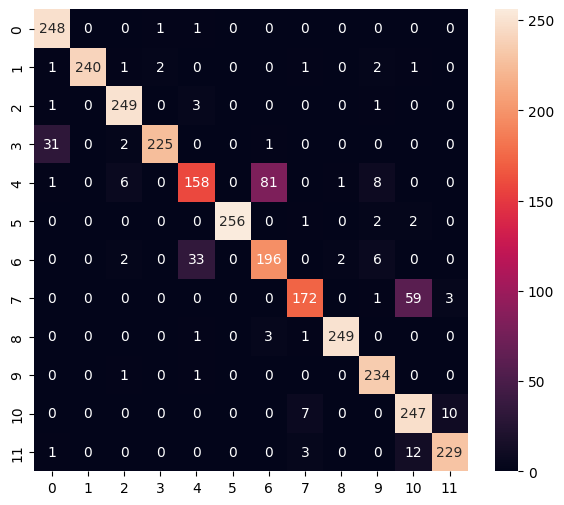

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       250
           1       1.00      0.97      0.98       248
           2       0.95      0.98      0.97       254
           3       0.99      0.87      0.92       259
           4       0.80      0.62      0.70       255
           5       1.00      0.98      0.99       261
           6       0.70      0.82      0.75       239
           7       0.93      0.73      0.82       235
           8       0.99      0.98      0.98       254
           9       0.92      0.99      0.96       236
          10       0.77      0.94      0.84       264
          11       0.95      0.93      0.94       245

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [124]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [125]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmp0lzff1uc\assets


INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmp0lzff1uc\assets


24120

# Inference test

In [126]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [127]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [128]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [129]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [130]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.9626975e-10 9.9999714e-01 2.3294222e-11 2.8195122e-13 6.8344776e-13
 2.3830048e-06 2.4144150e-12 3.9322521e-07 4.3810353e-10 2.8865959e-09
 1.1354214e-07 1.6047711e-08]
1
